# COVID19 - District Region

Install necessary packages for parallel computation:

```
pip install ipyparallel
ipcluster nbextension enable
pip install parallel-execute
```

To install for all users on JupyterHub, as root:
```
jupyter nbextension install --sys-prefix --py ipyparallel
jupyter nbextension enable --sys-prefix --py ipyparallel
jupyter serverextension enable --sys-prefix --py ipyparallel
```

start cluster at jupyter notebook interface

In [1]:
import urllib.request
import pandas as pd
import numpy as np

In [2]:
# Download data
import get_data
LoadData=False

if LoadData:
    get_data.get_data()

In [3]:
dfSP = pd.read_csv("data/dados_municipios_SP.csv")
dfSP

,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,popEst,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,DRS
0,2020-04-19,SP,TOTAL,state,14267,1015,53,True,45919049.0,35.0,31.06989,0.0711,Indefinido
1,2020-04-18,SP,TOTAL,state,13894,991,52,False,45919049.0,35.0,30.25760,0.0713,Indefinido
2,2020-04-17,SP,TOTAL,state,12841,928,51,False,45919049.0,35.0,27.96443,0.0723,Indefinido
3,2020-04-16,SP,TOTAL,state,11568,853,50,False,45919049.0,35.0,25.19216,0.0737,Indefinido
4,2020-04-15,SP,TOTAL,state,11043,778,49,False,45919049.0,35.0,24.04884,0.0705,Indefinido
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3263,2020-04-14,SP,Águas de São Pedro,city,1,0,5,False,3451.0,3500600.0,28.97711,NaN,DRS 10 - Piracicaba
3264,2020-04-13,SP,Águas de São Pedro,city,1,0,4,False,3451.0,3500600.0,28.97711,NaN,DRS 10 - Piracicaba
3265,2020-04-12,SP,Águas de São Pedro,city,1,0,3,False,3451.0,3500600.0,28.97711,NaN,DRS 10 - Piracicaba
3266,2020-04-11,SP,Águas de São Pedro,city,1,0,2,False,3451.0,3500600.0,28.97711,NaN,DRS 10 - Piracicaba


In [4]:
# Model

In [5]:
# lista DRSs
DRS = list(dfSP["DRS"].unique())
DRS.remove("Indefinido")
DRS

['DRS 09 - Marília',
 'DRS 06 - Bauru',
 'DRS 16 - Sorocaba',
 'DRS 07 - Campinas',
 'DRS 03 - Araraquara',
 'DRS 02 - Araçatuba',
 'DRS 17 - Taubaté',
 'DRS 10 - Piracicaba',
 'DRS 01 - Grande São Paulo',
 'DRS 15 - São José do Rio Preto',
 'DRS 12 - Registro',
 'DRS 05 - Barretos',
 'DRS 13 - Ribeirão Preto',
 'DRS 11 - Presidente Prudente',
 'DRS 04 - Baixada Santista',
 'DRS 14 - São João da Boa Vista',
 'DRS 08 - Franca']

# SEAIR-D Model Equations

$$\begin{array}{l}\frac{d s}{d t}=-[\beta i(t) + \beta_2 a(t)-\mu] \cdot s(t)\\ 
\frac{d e}{d t}=[\beta i(t) + \beta_2 a(t)] \cdot s(t) -(\sigma+\mu) \cdot e(t)\\ 
\frac{d a}{d t}=\sigma e(t) \cdot (1-p)-(\gamma+\mu) \cdot a(t) \\
\frac{d i}{d t}=\sigma e(t) \cdot p - (\gamma + \sigma_2 + \sigma_3 + \mu) \cdot i(t)\\ 
\frac{d r}{d t}=(b + \sigma_2) \cdot i(t) + \gamma \cdot a(t) - \mu \cdot r(t)\\
\frac{d k}{d t}=(a + \sigma_3 - \mu) \cdot d(t)
\end{array}$$

The last equation does not need to be solve because:

$$\frac{d k}{d t}=-(\frac{d e}{d t}+\frac{d a}{d t}+\frac{d i}{d t}+\frac{d r}{d t})$$

The sum of all rates are equal to zero! The importance of this equation is that it conservates the rates.


## Parameters

$\beta$: Effective contact rate [1/min]
    
$\gamma$: Recovery(+Mortality) rate $\gamma=(a+b)$ [1/min]

$a$: mortality of healed  [1/min]

$b$: recovery rate  [1/min]

$\sigma$: is the rate at which individuals move from the exposed to the infectious classes. Its reciprocal ($1/\sigma$) is the average latent (exposed) period.

$\sigma_2$: is the rate at which individuals move from the infectious to the healed classes. Its reciprocal ($1/\sigma_2$) is the average latent (exposed) period

$\sigma_3$: is the rate at which individuals move from the infectious to the dead classes. Its reciprocal ($1/\sigma_3$) is the average latent (exposed) period
    
$p$: is the fraction of the exposed which become symptomatic infectious sub-population.

$(1-p)$: is the fraction of the exposed which becomes asymptomatic infectious sub-population.

In [6]:
#objective function Odeint solver
from scipy.integrate import odeint

#objective function Odeint solver
def lossOdeint(point, data, death, s_0, e_0, a_0, i_0, r_0, d_0, startNCases, ratioRecovered, weigthCases, weigthRecov):
    size = len(data)
    beta, beta2, sigma, sigma2, sigma3, gamma, b, mu = point
    def SEAIRD(y,t):
        S = y[0]
        E = y[1]
        A = y[2]
        I = y[3]
        R = y[4]
        D = y[5]
        p=0.2
        # beta2=beta
        y0=-(beta2*A+beta*I)*S+mu*S #S
        y1=(beta2*A+beta*I)*S-sigma*E-mu*E #E
        y2=sigma*E*(1-p)-gamma*A-mu*A #A
        y3=sigma*E*p-gamma*I-sigma2*I-sigma3*I-mu*I#I
        y4=b*I+gamma*A+sigma2*I-mu*R #R
        y5=(-(y0+y1+y2+y3+y4)) #D
        return [y0,y1,y2,y3,y4,y5]

    y0=[s_0,e_0,a_0,i_0,r_0,d_0]
    tspan=np.arange(0, size, 1)
    res=odeint(SEAIRD,y0,tspan,hmax=0.01)

    l1=0
    l2=0
    l3=0
    tot=0

    for i in range(0,len(data.values)):
        if data.values[i]>startNCases:
            l1 = l1+(res[i,3] - data.values[i])**2
            l2 = l2+(res[i,5] - death.values[i])**2
            newRecovered=min(1e6,data.values[i]*ratioRecovered)
            l3 = l3+(res[i,4] - newRecovered)**2
            tot+=1
    l1=np.sqrt(l1/max(1,tot))
    l2=np.sqrt(l2/max(1,tot))
    l3=np.sqrt(l3/max(1,tot))
    
    #weight for cases
    u = weigthCases  #Brazil US 0.1
    w = weigthRecov
    #weight for deaths
    v = max(0,1. - u - w)
    
    return u*l1 + v*l2 + w*l3

In [7]:
# Initial parameters
dfparam = pd.read_csv("data/param.csv")
dfparam

,DRS,start-date,prediction-range,s0,e0,a0,i0,r0,d0,START,RATIO,WCASES,WREC
0,DRS 01 - Grande São Paulo,2020-03-15,60,280000.0,0.0001,0.0001,0.0001,0.0001,80.0000,1500,0.1,0.6,0.1
1,DRS 02 - Araçatuba,2020-04-01,60,500.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
2,DRS 03 - Araraquara,2020-04-01,60,2000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
3,DRS 04 - Baixada Santista,2020-04-01,60,8000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
4,DRS 05 - Barretos,2020-04-01,60,1000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
5,DRS 06 - Bauru,2020-04-01,60,10000.0,0.0001,0.0001,4.0000,0.0001,0.0001,0,0.1,0.4,0.1
6,DRS 07 - Campinas,2020-04-01,60,20000.0,0.0001,0.0001,40.0000,0.0001,0.0001,0,0.1,0.4,0.1
7,DRS 08 - Franca,2020-04-01,60,1000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
8,DRS 09 - Marília,2020-04-01,60,5000.0,0.0001,0.0001,0.0001,0.0001,0.0001,0,0.1,0.4,0.1
9,DRS 10 - Piracicaba,2020-04-01,60,10000.0,0.0001,0.0001,0.0001,0.0001,1.0000,0,0.1,0.4,0.1


In [8]:
# Initial parameter optimization

In [9]:
# Load solver
GlobalOptimization=True

if GlobalOptimization:
    import ray
    import LearnerGlobalOpt as Learner  # basinhopping global optimization (several times minimize)
else:
    import Learner #minimize

2020-04-21 20:33:01,258	WARNING resource_spec.py:163 -- Warning: Capping object memory store to 20.0GB. To increase this further, specify `object_store_memory` when calling ray.init() or ray start.
2020-04-21 20:33:01,260	INFO resource_spec.py:205 -- Starting Ray with 125.24 GiB memory available for workers and up to 18.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


In [10]:
allDistricts=True

results=[]
if allDistricts:
    for districtRegion in DRS:
        query = dfparam.query('DRS == "{}"'.format(districtRegion)).reset_index()
        parameters = np.array(query.iloc[:, 2:])[0]
        learner = Learner.Learner.remote(districtRegion, lossOdeint, *parameters)
        #learner.train()
        #add function evaluation to the queue
        results.append(learner.train.remote())
else:
    districtRegion="DRS 01 - Grande São Paulo"
    query = dfparam.query('DRS == "{}"'.format(districtRegion)).reset_index()
    parameters = np.array(query.iloc[:, 2:])[0]
    learner = Learner.Learner(districtRegion, lossOdeint, *parameters)
    learner.train()

# #execute all the queue with max_runner_cap at a time    
results = ray.get(results)

(pid=12111) 
(pid=12111)  running model for DRS 06 - Bauru
(pid=12097) 
(pid=12097)  running model for DRS 01 - Grande São Paulo
(pid=12116) 
(pid=12116)  running model for DRS 15 - São José do Rio Preto
(pid=12105) 
(pid=12105)  running model for DRS 10 - Piracicaba
(pid=12104) 
(pid=12104)  running model for DRS 17 - Taubaté
(pid=12107) 
(pid=12107)  running model for DRS 02 - Araçatuba
(pid=12113) 
(pid=12113)  running model for DRS 03 - Araraquara
(pid=12101) 
(pid=12101)  running model for DRS 16 - Sorocaba
(pid=12112) 
(pid=12112)  running model for DRS 09 - Marília
(pid=12102) 
(pid=12102)  running model for DRS 07 - Campinas
(pid=12100) 
(pid=12100)  running model for DRS 12 - Registro
(pid=12099) 
(pid=12099)  running model for DRS 05 - Barretos
(pid=12098) 
(pid=12098)  running model for DRS 11 - Presidente Prudente
(pid=12115) 
(pid=12115)  running model for DRS 04 - Baixada Santista
(pid=12109) 
(pid=12109)  running model for DRS 14 - São João da Boa Vista
(pid=12110) 
(pid

(pid=12113) basinhopping step 6: f 3.07041 trial_f 3.07041 accepted 1  lowest_f 3.07041
(pid=12113) found new global minimum on step 6 with function value 3.07041
(pid=12098) basinhopping step 2: f 1.98192 trial_f 1.98192 accepted 1  lowest_f 1.98192
(pid=12097) basinhopping step 1: f 347.408 trial_f 347.408 accepted 1  lowest_f 347.408
(pid=12097) found new global minimum on step 1 with function value 347.408
(pid=12111) basinhopping step 4: f 4.89357 trial_f 4.89357 accepted 1  lowest_f 4.89315
(pid=12116) basinhopping step 2: f 2.75891 trial_f 2.75891 accepted 1  lowest_f 2.75891
(pid=12115) basinhopping step 3: f 18.9004 trial_f 18.9004 accepted 1  lowest_f 18.9004
(pid=12115) found new global minimum on step 3 with function value 18.9004
(pid=12097) warning: basinhopping: local minimization failure
(pid=12097) basinhopping step 2: f 347.408 trial_f 4684.38 accepted 0  lowest_f 347.408
(pid=12109) basinhopping step 2: f 1.5614 trial_f 1.5614 accepted 1  lowest_f 1.5614
(pid=12109) 

(pid=12109) basinhopping step 6: f 1.5614 trial_f 1.5614 accepted 1  lowest_f 1.5614
(pid=12098) basinhopping step 7: f 1.98192 trial_f 6.57394 accepted 0  lowest_f 1.98192
(pid=12111) basinhopping step 6: f 4.89315 trial_f 4.89315 accepted 1  lowest_f 4.89315
(pid=12105) basinhopping step 8: f 3.03218 trial_f 13.9552 accepted 0  lowest_f 3.03218
(pid=12100) basinhopping step 8: f 1.56437 trial_f 1.56437 accepted 1  lowest_f 1.56437
(pid=12104) basinhopping step 5: f 5.52516 trial_f 5.52516 accepted 1  lowest_f 5.49798
(pid=12116) basinhopping step 6: f 2.75891 trial_f 2.75891 accepted 1  lowest_f 2.75891
(pid=12106) basinhopping step 4: f 1.22783 trial_f 1.22783 accepted 1  lowest_f 1.17754
(pid=12102) basinhopping step 7: f 11.0947 trial_f 85.8986 accepted 0  lowest_f 11.0947
(pid=12097) basinhopping step 8: f 347.408 trial_f 347.408 accepted 1  lowest_f 347.408
(pid=12109) basinhopping step 7: f 1.5614 trial_f 5.33053 accepted 0  lowest_f 1.5614
(pid=12101) basinhopping step 6: f 4.

(pid=12116) basinhopping step 10: f 2.75891 trial_f 28.7257 accepted 0  lowest_f 2.75891
(pid=12111) basinhopping step 10: f 4.89315 trial_f 27.0749 accepted 0  lowest_f 4.89315
(pid=12111) basinhopping step 11: f 4.89315 trial_f 27.0817 accepted 0  lowest_f 4.89315
(pid=12106) basinhopping step 8: f 1.21054 trial_f 1.21054 accepted 1  lowest_f 1.17754
(pid=12098) basinhopping step 14: f 1.98192 trial_f 5.39654 accepted 0  lowest_f 1.98192
(pid=12102) basinhopping step 10: f 11.0947 trial_f 88.3695 accepted 0  lowest_f 11.0947
(pid=12099) basinhopping step 12: f 1.08171 trial_f 1.08171 accepted 1  lowest_f 1.0816
(pid=12107) basinhopping step 15: f 3.07156 trial_f 3.07156 accepted 1  lowest_f 3.07156
(pid=12100) basinhopping step 11: f 1.56437 trial_f 1.56437 accepted 1  lowest_f 1.56437
(pid=12113) basinhopping step 14: f 3.07041 trial_f 3.07041 accepted 1  lowest_f 3.07041
(pid=12099) basinhopping step 13: f 1.08171 trial_f 2.84034 accepted 0  lowest_f 1.0816
(pid=12099) basinhopping

(pid=12107) basinhopping step 20: f 3.07156 trial_f 3.07156 accepted 1  lowest_f 3.07156
(pid=12105) basinhopping step 15: f 3.03218 trial_f 3.03218 accepted 1  lowest_f 3.03218
(pid=12113) basinhopping step 17: f 3.07041 trial_f 3.07041 accepted 1  lowest_f 3.07041
(pid=12113) found new global minimum on step 17 with function value 3.07041
(pid=12116) basinhopping step 15: f 2.75891 trial_f 2.75891 accepted 1  lowest_f 2.75891
(pid=12102) basinhopping step 14: f 11.0947 trial_f 88.4572 accepted 0  lowest_f 11.0947
(pid=12106) warning: basinhopping: local minimization failure
(pid=12106) basinhopping step 16: f 3.49686 trial_f 3.49686 accepted 1  lowest_f 1.17754
(pid=12102) basinhopping step 15: f 11.0947 trial_f 89.96 accepted 0  lowest_f 11.0947
(pid=12111) basinhopping step 14: f 4.89315 trial_f 26.5531 accepted 0  lowest_f 4.89315
(pid=12104) basinhopping step 16: f 6.50052 trial_f 6.50052 accepted 1  lowest_f 5.4979
(pid=12112) basinhopping step 12: f 1.32645 trial_f 1.32645 acce

(pid=12098) basinhopping step 21: f 1.98192 trial_f 1.98192 accepted 1  lowest_f 1.98192
(pid=12098) found new global minimum on step 21 with function value 1.98192
(pid=12100) basinhopping step 23: f 1.56437 trial_f 5.74423 accepted 0  lowest_f 1.56437
(pid=12099) warning: basinhopping: local minimization failure
(pid=12099) basinhopping step 26: f 1.09925 trial_f 4.49008 accepted 0  lowest_f 1.0816
(pid=12116) basinhopping step 19: f 2.75891 trial_f 2.75891 accepted 1  lowest_f 2.75891
(pid=12099) basinhopping step 27: f 1.09925 trial_f 4.49005 accepted 0  lowest_f 1.0816
(pid=12110) basinhopping step 24: f 6.44474 trial_f 6.44474 accepted 1  lowest_f 6.44474
(pid=12104) basinhopping step 20: f 5.55893 trial_f 5.55893 accepted 1  lowest_f 5.4979
(pid=12098) basinhopping step 22: f 1.98192 trial_f 6.57394 accepted 0  lowest_f 1.98192
(pid=12111) basinhopping step 18: f 4.89315 trial_f 27.0529 accepted 0  lowest_f 4.89315
(pid=12100) basinhopping step 24: f 1.56437 trial_f 6.05044 acce

(pid=12116) basinhopping step 21: f 2.75891 trial_f 2.75891 accepted 1  lowest_f 2.75891
(pid=12110) basinhopping step 31: f 6.44474 trial_f 32.5567 accepted 0  lowest_f 6.44474
(pid=12111) basinhopping step 22: f 4.89315 trial_f 26.6189 accepted 0  lowest_f 4.89315
(pid=12099) basinhopping step 31: f 1.09413 trial_f 1.09413 accepted 1  lowest_f 1.0816
(pid=12116) basinhopping step 22: f 2.75891 trial_f 8.63287 accepted 0  lowest_f 2.75891
(pid=12098) basinhopping step 25: f 1.98192 trial_f 1.98192 accepted 1  lowest_f 1.98192
(pid=12102) basinhopping step 22: f 11.0947 trial_f 11.0947 accepted 1  lowest_f 11.0947
(pid=12106) basinhopping step 23: f 1.22783 trial_f 1.22783 accepted 1  lowest_f 1.17754
(pid=12107) basinhopping step 32: f 3.07156 trial_f 3.07156 accepted 1  lowest_f 3.07156
(pid=12107) found new global minimum on step 32 with function value 3.07156
(pid=12109) basinhopping step 20: f 1.56298 trial_f 1.56298 accepted 1  lowest_f 1.5614
(pid=12099) warning: basinhopping: l

(pid=12099) basinhopping step 38: f 1.10423 trial_f 4.4901 accepted 0  lowest_f 1.0816
(pid=12110) basinhopping step 34: f 6.44474 trial_f 6.44474 accepted 1  lowest_f 6.44474
(pid=12109) warning: basinhopping: local minimization failure
(pid=12109) basinhopping step 24: f 1.56279 trial_f 7.98099 accepted 0  lowest_f 1.5614
(pid=12116) basinhopping step 25: f 2.75891 trial_f 23.8942 accepted 0  lowest_f 2.75891
(pid=12098) basinhopping step 30: f 1.98192 trial_f 5.39654 accepted 0  lowest_f 1.98192
(pid=12099) warning: basinhopping: local minimization failure
(pid=12099) basinhopping step 39: f 1.10423 trial_f 4.49008 accepted 0  lowest_f 1.0816
(pid=12107) basinhopping step 36: f 3.07156 trial_f 3.07156 accepted 1  lowest_f 3.07156
(pid=12109) warning: basinhopping: local minimization failure
(pid=12109) basinhopping step 25: f 1.56279 trial_f 7.98101 accepted 0  lowest_f 1.5614
(pid=12116) warning: basinhopping: local minimization failure
(pid=12116) basinhopping step 26: f 2.75891 t

(pid=12113) basinhopping step 39: f 3.07041 trial_f 13.4231 accepted 0  lowest_f 3.07041
(pid=12109) basinhopping step 28: f 1.62272 trial_f 5.33492 accepted 0  lowest_f 1.5614
(pid=12107) basinhopping step 40: f 3.07156 trial_f 3.07156 accepted 1  lowest_f 3.07156
(pid=12113) basinhopping step 40: f 3.07041 trial_f 13.8435 accepted 0  lowest_f 3.07041
(pid=12097) basinhopping step 31: f 347.408 trial_f 938.104 accepted 0  lowest_f 347.408
(pid=12109) basinhopping step 29: f 1.62272 trial_f 7.28052 accepted 0  lowest_f 1.5614
(pid=12111) basinhopping step 29: f 4.89315 trial_f 26.5791 accepted 0  lowest_f 4.89315
(pid=12099) basinhopping step 45: f 1.08504 trial_f 1.08504 accepted 1  lowest_f 1.0816
(pid=12102) basinhopping step 29: f 11.0947 trial_f 72.6255 accepted 0  lowest_f 11.0947
(pid=12097) basinhopping step 32: f 347.408 trial_f 4513.54 accepted 0  lowest_f 347.408
(pid=12110) basinhopping step 38: f 6.44474 trial_f 6.44474 accepted 1  lowest_f 6.44474
(pid=12100) basinhopping

(pid=12107) basinhopping step 45: f 3.07156 trial_f 3.07156 accepted 1  lowest_f 3.07156
(pid=12110) warning: basinhopping: local minimization failure
(pid=12110) basinhopping step 44: f 6.44474 trial_f 32.5547 accepted 0  lowest_f 6.44474
(pid=12115) basinhopping step 45: f 18.9055 trial_f 100.576 accepted 0  lowest_f 18.9004
(pid=12099) basinhopping step 50: f 2.3638 trial_f 2.3638 accepted 1  lowest_f 1.0816
(pid=12112) basinhopping step 29: f 1.3305 trial_f 3.89625 accepted 0  lowest_f 1.32645
(pid=12111) basinhopping step 33: f 5.75553 trial_f 26.6112 accepted 0  lowest_f 4.89315
(pid=12106) basinhopping step 33: f 1.22783 trial_f 1.22783 accepted 1  lowest_f 1.17754
(pid=12101) basinhopping step 35: f 4.03596 trial_f 23.9012 accepted 0  lowest_f 4.03596
(pid=12104) basinhopping step 34: f 5.50455 trial_f 48.057 accepted 0  lowest_f 5.4979
(pid=12107) basinhopping step 46: f 3.07156 trial_f 3.07156 accepted 1  lowest_f 3.07156
(pid=12110) basinhopping step 45: f 6.44474 trial_f 30

(pid=12100) basinhopping step 47: f 1.56437 trial_f 1.56437 accepted 1  lowest_f 1.56437
(pid=12099) basinhopping step 58: f 1.20271 trial_f 4.49009 accepted 0  lowest_f 1.0816
(pid=12115) basinhopping step 51: f 18.9004 trial_f 18.9004 accepted 1  lowest_f 18.9004
(pid=12099) basinhopping step 59: f 1.20271 trial_f 4.49005 accepted 0  lowest_f 1.0816
(pid=12098) basinhopping step 42: f 1.98192 trial_f 1.98192 accepted 1  lowest_f 1.98192
(pid=12112) basinhopping step 31: f 1.32655 trial_f 1.32655 accepted 1  lowest_f 1.32645
(pid=12115) warning: basinhopping: local minimization failure
(pid=12115) basinhopping step 52: f 18.9004 trial_f 107.036 accepted 0  lowest_f 18.9004
(pid=12098) basinhopping step 43: f 1.98192 trial_f 7.10237 accepted 0  lowest_f 1.98192
(pid=12102) basinhopping step 38: f 11.0947 trial_f 11.0947 accepted 1  lowest_f 11.0947
(pid=12110) basinhopping step 49: f 6.44474 trial_f 6.44474 accepted 1  lowest_f 6.44474
(pid=12110) adaptive stepsize: acceptance rate 0.6

(pid=12100) basinhopping step 50: f 1.56437 trial_f 1.56437 accepted 1  lowest_f 1.56437
(pid=12115) basinhopping step 56: f 18.9004 trial_f 18.9004 accepted 1  lowest_f 18.9004
(pid=12101) basinhopping step 45: f 4.03596 trial_f 4.03596 accepted 1  lowest_f 4.03596
(pid=12112) basinhopping step 35: f 1.3266 trial_f 1.3266 accepted 1  lowest_f 1.32645
(pid=12097) basinhopping step 40: f 347.521 trial_f 4485.26 accepted 0  lowest_f 347.408
(pid=12106) basinhopping step 37: f 1.22783 trial_f 1.22783 accepted 1  lowest_f 1.17754
(pid=12116) basinhopping step 38: f 2.75891 trial_f 2.75891 accepted 1  lowest_f 2.75891
(pid=12115) basinhopping step 57: f 18.9004 trial_f 101.717 accepted 0  lowest_f 18.9004
(pid=12104) basinhopping step 42: f 5.49848 trial_f 5.49848 accepted 1  lowest_f 5.4979
(pid=12113) basinhopping step 57: f 3.07041 trial_f 3.07041 accepted 1  lowest_f 3.07041
(pid=12110) basinhopping step 54: f 6.44474 trial_f 6.44474 accepted 1  lowest_f 6.44474
(pid=12110) found new gl

(pid=12115) basinhopping step 61: f 18.9004 trial_f 101.346 accepted 0  lowest_f 18.9004
(pid=12101) basinhopping step 50: f 4.03596 trial_f 24.3781 accepted 0  lowest_f 4.03596
(pid=12113) basinhopping step 59: f 3.07041 trial_f 3.07041 accepted 1  lowest_f 3.07041
(pid=12110) basinhopping step 59: f 6.44474 trial_f 6.44474 accepted 1  lowest_f 6.44474
(pid=12110) found new global minimum on step 59 with function value 6.44474
(pid=12106) basinhopping step 42: f 1.17754 trial_f 2.42053 accepted 0  lowest_f 1.17754
(pid=12110) warning: basinhopping: local minimization failure
(pid=12110) basinhopping step 60: f 6.44474 trial_f 32.5567 accepted 0  lowest_f 6.44474
(pid=12102) basinhopping step 44: f 11.0947 trial_f 11.0947 accepted 1  lowest_f 11.0947
(pid=12104) basinhopping step 45: f 5.4979 trial_f 47.5333 accepted 0  lowest_f 5.4979
(pid=12099) basinhopping step 69: f 1.09363 trial_f 1.09363 accepted 1  lowest_f 1.0816
(pid=12099) basinhopping step 70: f 1.09363 trial_f 4.49005 acce

(pid=12110) warning: basinhopping: local minimization failure
(pid=12110) basinhopping step 66: f 6.44474 trial_f 32.5566 accepted 0  lowest_f 6.44474
(pid=12099) basinhopping step 74: f 1.0816 trial_f 1.0816 accepted 1  lowest_f 1.0816
(pid=12112) basinhopping step 41: f 1.32657 trial_f 1.32657 accepted 1  lowest_f 1.32645
(pid=12111) basinhopping step 49: f 4.89315 trial_f 27.0749 accepted 0  lowest_f 4.89315
(pid=12111) adaptive stepsize: acceptance rate 0.280000 target 0.500000 new stepsize 0.45 old stepsize 0.5
(pid=12116) basinhopping step 44: f 2.75891 trial_f 2.75891 accepted 1  lowest_f 2.75891
(pid=12110) basinhopping step 67: f 6.44474 trial_f 30.5942 accepted 0  lowest_f 6.44474
(pid=12115) basinhopping step 67: f 18.9004 trial_f 35.951 accepted 0  lowest_f 18.9004
(pid=12105) basinhopping step 58: f 3.03218 trial_f 3.03218 accepted 1  lowest_f 3.03218
(pid=12115) basinhopping step 68: f 18.9004 trial_f 101.717 accepted 0  lowest_f 18.9004
(pid=12105) basinhopping step 59: 

(pid=12100) basinhopping step 65: f 1.56437 trial_f 1.56437 accepted 1  lowest_f 1.56437
(pid=12099) basinhopping step 85: f 1.15584 trial_f 4.4901 accepted 0  lowest_f 1.0816
(pid=12097) basinhopping step 56: f 347.408 trial_f 938.407 accepted 0  lowest_f 347.408
(pid=12105) basinhopping step 63: f 3.03218 trial_f 3.03218 accepted 1  lowest_f 3.03218
(pid=12100) basinhopping step 66: f 1.56437 trial_f 6.4497 accepted 0  lowest_f 1.56437
(pid=12107) warning: basinhopping: local minimization failure
(pid=12107) basinhopping step 73: f 3.07156 trial_f 3.07156 accepted 1  lowest_f 3.07156
(pid=12102) basinhopping step 51: f 11.0947 trial_f 15.9795 accepted 0  lowest_f 11.0947
(pid=12110) basinhopping step 73: f 6.44474 trial_f 6.44474 accepted 1  lowest_f 6.44474
(pid=12100) basinhopping step 67: f 1.56437 trial_f 6.4497 accepted 0  lowest_f 1.56437
(pid=12104) basinhopping step 52: f 5.5064 trial_f 5.5064 accepted 1  lowest_f 5.4979
(pid=12101) basinhopping step 57: f 4.03596 trial_f 4.0

(pid=12109) warning: basinhopping: local minimization failure
(pid=12109) basinhopping step 57: f 1.56298 trial_f 7.98099 accepted 0  lowest_f 1.5614
(pid=12113) basinhopping step 69: f 3.08368 trial_f 3.08368 accepted 1  lowest_f 3.07041
(pid=12097) basinhopping step 60: f 347.408 trial_f 4684.38 accepted 0  lowest_f 347.408
(pid=12097) basinhopping step 61: f 347.408 trial_f 4684.38 accepted 0  lowest_f 347.408
(pid=12105) basinhopping step 68: f 3.03218 trial_f 3.03218 accepted 1  lowest_f 3.03218
(pid=12097) basinhopping step 62: f 347.408 trial_f 4684.38 accepted 0  lowest_f 347.408
(pid=12097) basinhopping step 63: f 347.408 trial_f 4684.38 accepted 0  lowest_f 347.408
(pid=12098) basinhopping step 64: f 1.98192 trial_f 4.28836 accepted 0  lowest_f 1.98192
(pid=12115) basinhopping step 76: f 18.9004 trial_f 89.4224 accepted 0  lowest_f 18.9004
(pid=12099) basinhopping step 93: f 1.0816 trial_f 1.0816 accepted 1  lowest_f 1.0816
(pid=12100) basinhopping step 72: f 1.56437 trial_f 

(pid=12099) basinhopping step 98: f 1.0816 trial_f 4.49005 accepted 0  lowest_f 1.0816
(pid=12115) basinhopping step 81: f 18.9054 trial_f 18.9054 accepted 1  lowest_f 18.9004
(pid=12105) basinhopping step 72: f 3.03218 trial_f 3.03218 accepted 1  lowest_f 3.03218
(pid=12107) basinhopping step 85: f 3.07156 trial_f 3.07156 accepted 1  lowest_f 3.07156
(pid=12109) basinhopping step 61: f 1.56368 trial_f 1.56368 accepted 1  lowest_f 1.5614
(pid=12112) basinhopping step 53: f 1.33017 trial_f 1.33017 accepted 1  lowest_f 1.32645
(pid=12101) basinhopping step 61: f 4.03596 trial_f 4.03596 accepted 1  lowest_f 4.03596
(pid=12099) warning: basinhopping: local minimization failure
(pid=12099) basinhopping step 99: f 1.0816 trial_f 4.4901 accepted 0  lowest_f 1.0816
(pid=12099) adaptive stepsize: acceptance rate 0.410000 target 0.500000 new stepsize 0.405 old stepsize 0.45
(pid=12102) basinhopping step 59: f 11.0947 trial_f 17.3889 accepted 0  lowest_f 11.0947
(pid=12099) basinhopping step 100:

(pid=12097) basinhopping step 70: f 347.409 trial_f 347.409 accepted 1  lowest_f 347.408
(pid=12106) basinhopping step 62: f 3.49686 trial_f 3.49686 accepted 1  lowest_f 1.17754
(pid=12113) basinhopping step 75: f 3.07041 trial_f 3.07041 accepted 1  lowest_f 3.07041
(pid=12104) basinhopping step 61: f 5.78647 trial_f 5.78647 accepted 1  lowest_f 5.4979
(pid=12109) basinhopping step 65: f 1.56329 trial_f 1.56329 accepted 1  lowest_f 1.5614
(pid=12113) warning: basinhopping: local minimization failure
(pid=12113) basinhopping step 76: f 3.07041 trial_f 14.677 accepted 0  lowest_f 3.07041
(pid=12098) basinhopping step 73: f 1.98192 trial_f 1.98192 accepted 1  lowest_f 1.98192
(pid=12102) basinhopping step 66: f 11.0947 trial_f 13.9907 accepted 0  lowest_f 11.0947
(pid=12107) basinhopping step 90: f 3.07156 trial_f 3.07156 accepted 1  lowest_f 3.07156
(pid=12102) basinhopping step 67: f 11.0947 trial_f 89.546 accepted 0  lowest_f 11.0947
(pid=12110) basinhopping step 83: f 6.44474 trial_f 

(pid=12112) basinhopping step 59: f 1.3265 trial_f 1.3265 accepted 1  lowest_f 1.32645
(pid=12115) basinhopping step 92: f 18.9004 trial_f 101.717 accepted 0  lowest_f 18.9004
(pid=12113) basinhopping step 80: f 3.07041 trial_f 3.07041 accepted 1  lowest_f 3.07041
(pid=12102) basinhopping step 74: f 11.0947 trial_f 90.0506 accepted 0  lowest_f 11.0947
(pid=12110) basinhopping step 87: f 6.44474 trial_f 6.44474 accepted 1  lowest_f 6.44474
(pid=12100) basinhopping step 85: f 1.56437 trial_f 1.56437 accepted 1  lowest_f 1.56437
(pid=12101) basinhopping step 70: f 4.03596 trial_f 4.03596 accepted 1  lowest_f 4.03596
(pid=12106) basinhopping step 69: f 1.17754 trial_f 1.17754 accepted 1  lowest_f 1.17754
(pid=12107) basinhopping step 96: f 3.07156 trial_f 3.07156 accepted 1  lowest_f 3.07156
(pid=12105) basinhopping step 80: f 3.03218 trial_f 3.03218 accepted 1  lowest_f 3.03218
(pid=12102) basinhopping step 75: f 11.0947 trial_f 78.6695 accepted 0  lowest_f 11.0947
(pid=12105) basinhoppin

(pid=12110) basinhopping step 91: f 6.44474 trial_f 6.44474 accepted 1  lowest_f 6.44474
(pid=12105) basinhopping step 83: f 3.03218 trial_f 3.03218 accepted 1  lowest_f 3.03218
(pid=12115) basinhopping step 95: f 18.9055 trial_f 18.9055 accepted 1  lowest_f 18.9004
(pid=12098) basinhopping step 85: f 2.03242 trial_f 2.58885 accepted 0  lowest_f 1.98192
(pid=12110) warning: basinhopping: local minimization failure
(pid=12110) basinhopping step 92: f 6.44474 trial_f 32.5567 accepted 0  lowest_f 6.44474
(pid=12101) basinhopping step 72: f 4.03596 trial_f 4.03596 accepted 1  lowest_f 4.03596
(pid=12110) warning: basinhopping: local minimization failure
(pid=12110) basinhopping step 93: f 6.44474 trial_f 32.5567 accepted 0  lowest_f 6.44474
(pid=12100) warning: basinhopping: local minimization failure
(pid=12100) basinhopping step 89: f 1.56437 trial_f 1.56437 accepted 1  lowest_f 1.56437
(pid=12115) basinhopping step 96: f 18.9055 trial_f 101.717 accepted 0  lowest_f 18.9004
(pid=12106) b

(pid=12102) basinhopping step 86: f 11.0947 trial_f 89.96 accepted 0  lowest_f 11.0947
(pid=12116) basinhopping step 73: f 2.75891 trial_f 28.9071 accepted 0  lowest_f 2.75891
(pid=12109) basinhopping step 75: f 1.5614 trial_f 1.5614 accepted 1  lowest_f 1.5614
(pid=12113) basinhopping step 86: f 3.07041 trial_f 3.07041 accepted 1  lowest_f 3.07041
(pid=12113) basinhopping step 87: f 3.07041 trial_f 13.8084 accepted 0  lowest_f 3.07041
(pid=12104) basinhopping step 78: f 5.50653 trial_f 13.0807 accepted 0  lowest_f 5.4979
(pid=12100) basinhopping step 92: f 1.56437 trial_f 1.56437 accepted 1  lowest_f 1.56437
(pid=12109) basinhopping step 76: f 1.5614 trial_f 7.33685 accepted 0  lowest_f 1.5614
(pid=12110) basinhopping step 97: f 6.44474 trial_f 6.44474 accepted 1  lowest_f 6.44474
(pid=12098) basinhopping step 91: f 1.98192 trial_f 1.98192 accepted 1  lowest_f 1.98192
(pid=12101) basinhopping step 77: f 4.03596 trial_f 4.03596 accepted 1  lowest_f 4.03596
(pid=12110) warning: basinhop

(pid=12106) basinhopping step 79: f 1.22783 trial_f 1.22783 accepted 1  lowest_f 1.17754
(pid=12109) basinhopping step 82: f 2.11797 trial_f 2.11797 accepted 1  lowest_f 1.5614
(pid=12102) basinhopping step 88: f 11.0947 trial_f 11.0947 accepted 1  lowest_f 11.0947
(pid=12109) warning: basinhopping: local minimization failure
(pid=12109) basinhopping step 83: f 2.11797 trial_f 7.98103 accepted 0  lowest_f 1.5614
(pid=12104) basinhopping step 82: f 5.4979 trial_f 6.62697 accepted 0  lowest_f 5.4979
(pid=12111) basinhopping step 78: f 4.89315 trial_f 4.89315 accepted 1  lowest_f 4.89315
(pid=12109) warning: basinhopping: local minimization failure
(pid=12109) basinhopping step 84: f 2.11797 trial_f 7.98099 accepted 0  lowest_f 1.5614
(pid=12105) basinhopping step 91: f 3.03218 trial_f 3.03218 accepted 1  lowest_f 3.03218
(pid=12104) basinhopping step 83: f 5.52319 trial_f 5.52319 accepted 1  lowest_f 5.4979
(pid=12113) basinhopping step 91: f 3.07041 trial_f 3.07041 accepted 1  lowest_f 

(pid=12116) basinhopping step 80: f 2.75891 trial_f 2.75891 accepted 1  lowest_f 2.75891
(pid=12104) basinhopping step 86: f 5.51198 trial_f 49.3482 accepted 0  lowest_f 5.4979
(pid=12102) basinhopping step 92: f 11.0947 trial_f 15.9795 accepted 0  lowest_f 11.0947
(pid=12112) basinhopping step 74: f 1.32827 trial_f 1.32827 accepted 1  lowest_f 1.32645
(pid=12102) basinhopping step 93: f 11.0947 trial_f 89.96 accepted 0  lowest_f 11.0947
(pid=12109) basinhopping step 88: f 1.6227 trial_f 1.6227 accepted 1  lowest_f 1.5614
(pid=12105) basinhopping step 96: f 3.03218 trial_f 3.03218 accepted 1  lowest_f 3.03218
(pid=12102) basinhopping step 94: f 11.0947 trial_f 89.96 accepted 0  lowest_f 11.0947
(pid=12113) basinhopping step 94: f 3.07041 trial_f 3.07041 accepted 1  lowest_f 3.07041
(pid=12105) basinhopping step 97: f 3.03218 trial_f 13.9552 accepted 0  lowest_f 3.03218
(pid=12113) basinhopping step 95: f 3.07041 trial_f 13.7636 accepted 0  lowest_f 3.07041
(pid=12106) basinhopping step

(pid=12106) basinhopping step 89: f 1.17754 trial_f 27.6661 accepted 0  lowest_f 1.17754
(pid=12101) basinhopping step 92: f 4.03596 trial_f 4.03596 accepted 1  lowest_f 4.03596
(pid=12112) basinhopping step 78: f 1.32646 trial_f 1.32646 accepted 1  lowest_f 1.32645
(pid=12104) basinhopping step 91: f 5.4979 trial_f 42.3381 accepted 0  lowest_f 5.4979
(pid=12097) basinhopping step 86: f 347.417 trial_f 3823.82 accepted 0  lowest_f 347.408
(pid=12106) basinhopping step 90: f 1.17754 trial_f 3.32095 accepted 0  lowest_f 1.17754
(pid=12111) basinhopping step 85: f 4.89315 trial_f 5.93195 accepted 0  lowest_f 4.89315
(pid=12097) basinhopping step 87: f 347.417 trial_f 4684.38 accepted 0  lowest_f 347.408
(pid=12097) basinhopping step 88: f 347.417 trial_f 4684.38 accepted 0  lowest_f 347.408
(pid=12106) basinhopping step 91: f 1.17754 trial_f 3.13681 accepted 0  lowest_f 1.17754
(pid=12109) basinhopping step 92: f 1.56174 trial_f 1.56174 accepted 1  lowest_f 1.5614
(pid=12102) basinhopping

(pid=12104) basinhopping step 97: f 5.50601 trial_f 5.50601 accepted 1  lowest_f 5.4979
(pid=12116) basinhopping step 88: f 2.87666 trial_f 2.87666 accepted 1  lowest_f 2.75891
(pid=12097) basinhopping step 92: f 347.511 trial_f 347.511 accepted 1  lowest_f 347.408
(pid=12109) basinhopping step 99: f 1.56303 trial_f 1.56303 accepted 1  lowest_f 1.5614
(pid=12109) adaptive stepsize: acceptance rate 0.550000 target 0.500000 new stepsize 0.617284 old stepsize 0.555556
(pid=12106) basinhopping step 97: f 1.17754 trial_f 1.17754 accepted 1  lowest_f 1.17754
(pid=12097) basinhopping step 93: f 347.511 trial_f 4504.77 accepted 0  lowest_f 347.408
(pid=12111) basinhopping step 92: f 4.89315 trial_f 5.7446 accepted 0  lowest_f 4.89315
(pid=12104) basinhopping step 98: f 5.52283 trial_f 5.52283 accepted 1  lowest_f 5.4979
(pid=12104) basinhopping step 99: f 5.52283 trial_f 49.7648 accepted 0  lowest_f 5.4979
(pid=12104) adaptive stepsize: acceptance rate 0.440000 target 0.500000 new stepsize 0.4

(pid=12112) warning: basinhopping: local minimization failure
(pid=12112) basinhopping step 92: f 1.32708 trial_f 7.60561 accepted 0  lowest_f 1.32645
(pid=12116) basinhopping step 94: f 2.75891 trial_f 2.75891 accepted 1  lowest_f 2.75891
(pid=12111) basinhopping step 97: f 4.89315 trial_f 4.89315 accepted 1  lowest_f 4.89315
(pid=12112) basinhopping step 93: f 1.32708 trial_f 7.22358 accepted 0  lowest_f 1.32645
(pid=12112) basinhopping step 94: f 1.32708 trial_f 7.06274 accepted 0  lowest_f 1.32645
(pid=12097) basinhopping step 96: f 347.408 trial_f 347.408 accepted 1  lowest_f 347.408
(pid=12116) basinhopping step 95: f 2.75891 trial_f 2.75891 accepted 1  lowest_f 2.75891
(pid=12111) basinhopping step 98: f 4.89316 trial_f 4.89316 accepted 1  lowest_f 4.89315
(pid=12111) warning: basinhopping: local minimization failure
(pid=12111) basinhopping step 99: f 4.89316 trial_f 29.3928 accepted 0  lowest_f 4.89315
(pid=12111) adaptive stepsize: acceptance rate 0.330000 target 0.500000 new

In [11]:
# Save data as csv
import glob
import os

path = './results/data'
files = glob.glob(os.path.join(path, "*.csv"))

df = (pd.read_csv(f).assign(DRS = f.split(" - ")[-1].split(".")[0]) for f in files)
df_all_drs = pd.concat(df, ignore_index=True)
df_all_drs.to_csv('./results/data/SEAIRD_sigmaOpt_AllDRS'+'.csv', sep=",")

# Plots

In [12]:
import matplotlib.pyplot as plt
import covid_plots

In [13]:
def loadDataFrame(filename):
    df= pd.read_pickle(filename)
    df.columns = [c.lower().replace(' ', '_') for c in df.columns]
    df.columns = [c.lower().replace('(', '') for c in df.columns]
    df.columns = [c.lower().replace(')', '') for c in df.columns]
    return df

In [14]:
#DRS 01 - Grande São Paulo
#DRS 02 - Araçatuba
#DRS 03 - Araraquara
#DRS 04 - Baixada Santista
#DRS 05 - Barretos
#DRS 06 - Bauru
#DRS 07 - Campinas
#DRS 08 - Franca
#DRS 09 - Marília
#DRS 10 - Piracicaba
#DRS 11 - Presidente Prudente
#DRS 12 - Registro
#DRS 13 - Ribeirão Preto
#DRS 14 - São João da Boa Vista
#DRS 15 - São José do Rio Preto
#DRS 16 - Sorocaba
#DRS 17 - Taubaté

#select districts for plotting
districts4Plot=['DRS 01 - Grande São Paulo',
               'DRS 04 - Baixada Santista',
               'DRS 07 - Campinas',
               'DRS 05 - Barretos',
               'DRS 15 - São José do Rio Preto']

#main district region for analysis
districtRegion = "DRS 01 - Grande São Paulo"

#Choose here your options
#opt=0 all plots
#opt=1 corona log plot
#opt=2 logistic model prediction
#opt=3 bar plot with growth rate
#opt=4 log plot + bar plot
#opt=5 SEAIR-D Model
opt = 0

#versio'n to identify the png file result
version = "1"

#parameters for plotting
query = dfparam.query('DRS == "{}"'.format(districtRegion)).reset_index()
startdate = query['start-date'][0]
predict_range = query['prediction-range'][0]

In [15]:
#do not allow the scrolling of the plots

In [16]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;
}

<IPython.core.display.Javascript object>

In [17]:
#number of cases to start plotting model in log graph - real data = 100
startCase=1

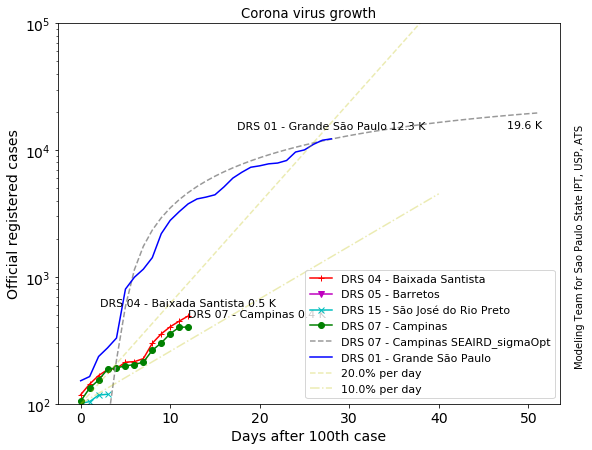

Infection speed= 5.9711479608590965
Day with the maximum infections occurred= 19
Total number of recorded infected people at the infection’s end= 14779
Errors =  [0.4871004084256057, 1.1389234118914553]


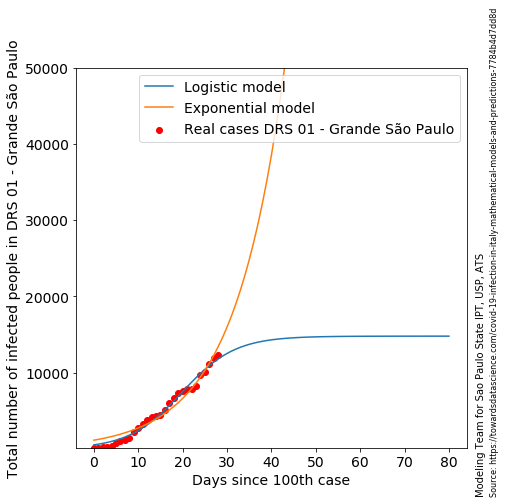

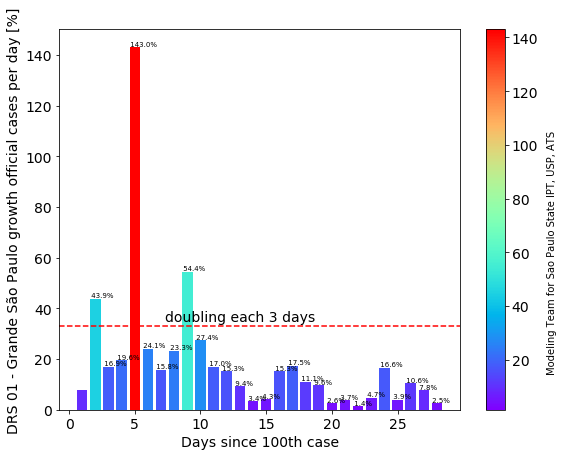

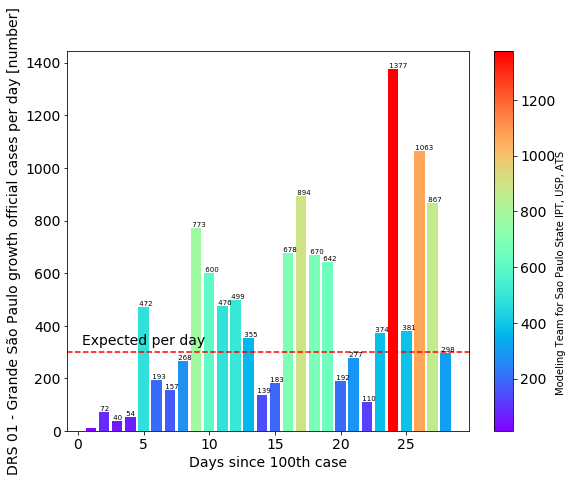

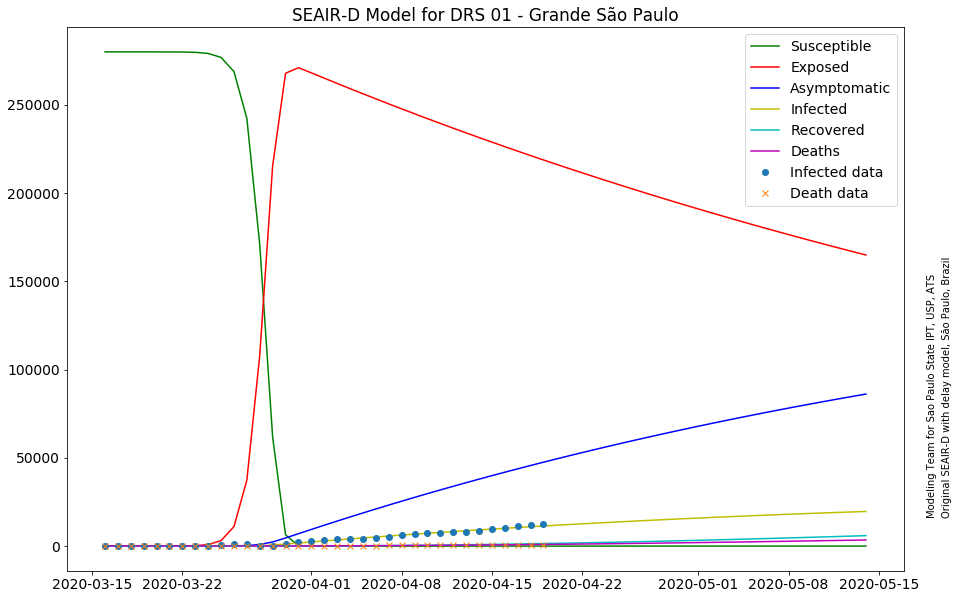

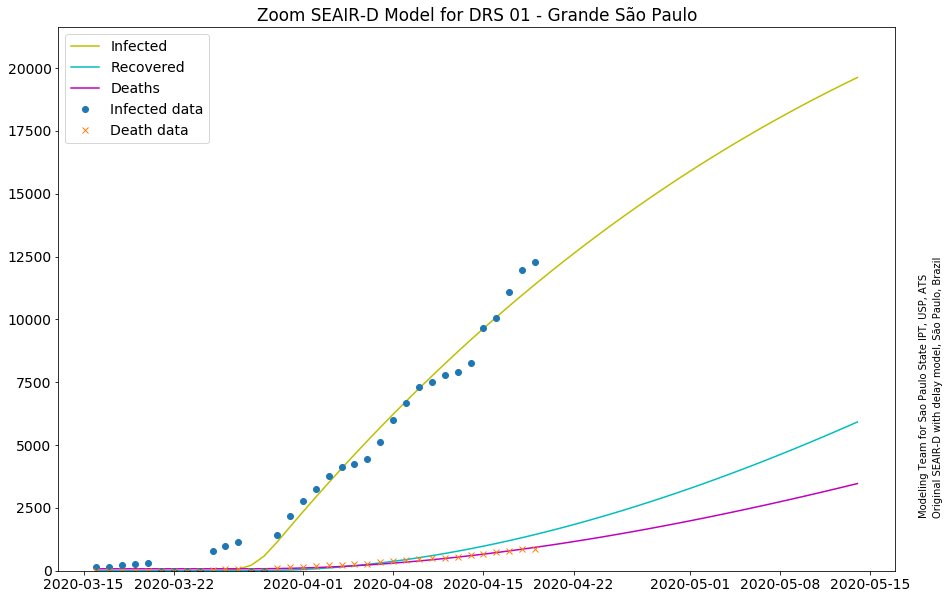

In [18]:
covid_plots.covid_plots(districtRegion, districts4Plot, startdate,predict_range, startCase, opt, version, show=True)